In [5]:
# Use seaborn for pairplot
!pip3 install -q seaborn

# Use some functions from tensorflow_docs
!pip3 install -q git+https://github.com/tensorflow/docs
    
#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

## tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
print(tf.__version__)

2.1.0


In [17]:
## get data
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
print(type(dataset))
dataset.tail()

/home/pingjui/.keras/datasets/auto-mpg.data
<class 'pandas.core.frame.DataFrame'>


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [18]:
## check N/A situation
print(dataset.isna().sum())


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [19]:
## clean the data
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


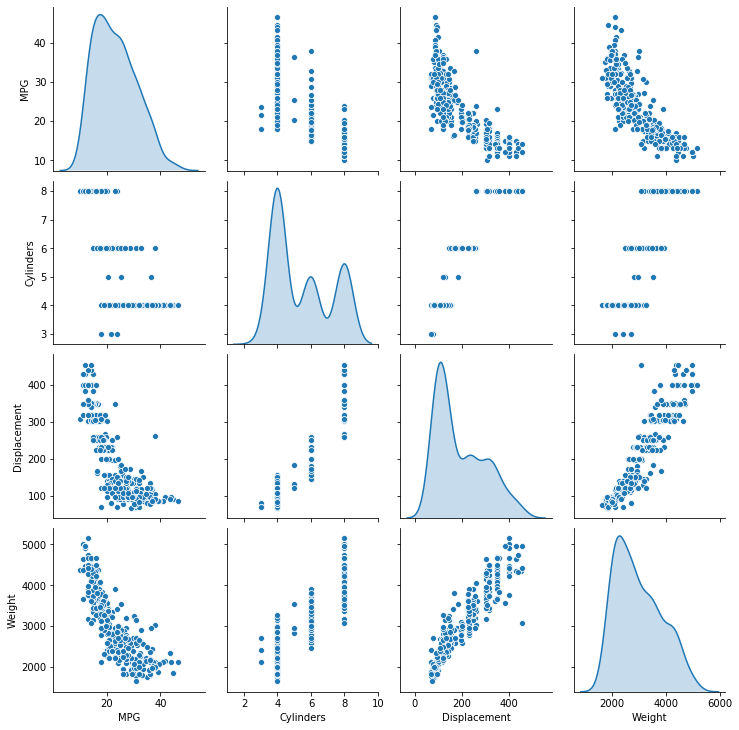

In [22]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [23]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [24]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [25]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [27]:
EPOCHS = 1000

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
model.summary()


## try whether it's working ( correct dimension of sample/labels )
# example_batch = normed_train_data[:10]
# example_result = model.predict(example_batch)
# example_result

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:568.5005,  mae:22.6310,  mse:568.5004,  val_loss:556.0089,  val_mae:22.3473,  val_mse:556.0089,  
....................................................................................................
Epoch: 100, loss:5.9317,  mae:1.6806,  mse:5.9317,  val_loss:8.4571,  val_mae:2.2190,  val_mse:8.4571,  
..............................................................

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.281085,0.973686,2.281085,8.618070,2.303033,8.618070,995
996,2.329188,1.004082,2.329188,8.804663,2.375717,8.804663,996
997,2.384641,1.001626,2.384641,7.959352,2.263575,7.959352,997
998,2.360640,0.994869,2.360641,7.754899,2.213158,7.754900,998
999,2.493510,1.071064,2.493510,8.745317,2.357535,8.745317,999


NameError: name 'Text' is not defined

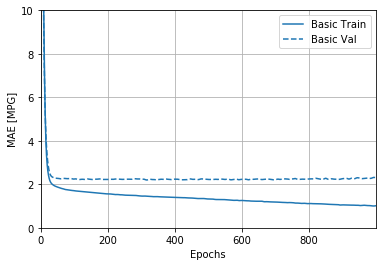

In [32]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
# Text(0, 0.5, 'MSE [MPG^2]')

# Early stoping
## rebuild a model of early stopping

In [33]:
# The patience parameter is the amount of epochs to check for improvement
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:582.4847,  mae:22.8545,  mse:582.4847,  val_loss:572.0150,  val_mae:22.6255,  val_mse:572.0150,  
.....................................................

Text(0, 0.5, 'MAE [MPG]')

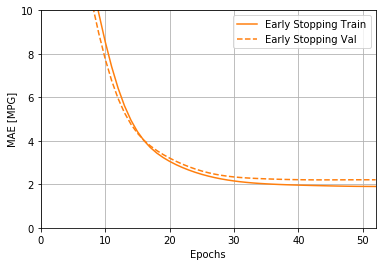

In [35]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

78/78 - 0s - loss: 5.8135 - mae: 1.7896 - mse: 5.8135
Testing set Mean Abs Error:  1.79 MPG


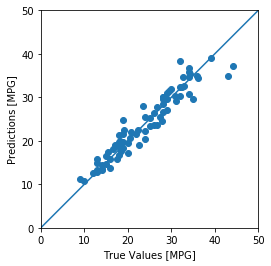

In [38]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



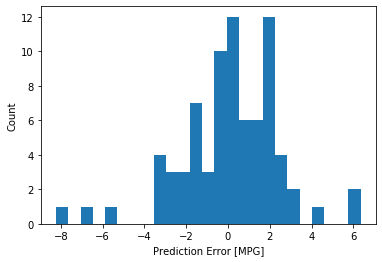

In [39]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")